# Collaborative Filtering and Attribute Modelling

## 1. Importing the Packages

In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np
import shap
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

## 2. Loading the Dataset

In [7]:
try:
    listings_df = pd.read_csv('listings_metadata (1).csv')
    user_data_df = pd.read_csv('user_41399220_analysis (1).csv')
except Exception as e:
    print(f"Error loading files: {e}")
    exit()

In [8]:
# Ensure 'listing_id' is of the same type in both datasets
listings_df['listing_id'] = listings_df['listing_id'].astype(str)
user_data_df['listing_id'] = user_data_df['listing_id'].astype(str)

In [9]:
# merging the datasets
try:
    merged_df = pd.merge(listings_df, user_data_df, on='listing_id', how='inner')
except Exception as e:
    print(f"Error merging datasets: {e}")
    exit()

## 3. Data Preprocessing

In [11]:
# Convert necessary columns to numeric
numeric_cols = ['price', 'listing_age']
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Select features for Collaborative Filtering (excluding missing ones)
cf_df = merged_df.dropna(subset=numeric_cols)  # Remove rows with missing values

## 4. Collaborative Filtering

In [32]:
# Collaborative Filtering using SVD 
# SVD is Singular Value Decomposition
svd = TruncatedSVD(n_components=2)
listing_factors = svd.fit_transform(cf_df[numeric_cols])
listing_similarity = cosine_similarity(listing_factors)

In [14]:
# Create similarity matrix DataFrame
similarity_df = pd.DataFrame(listing_similarity, index=cf_df['listing_id'], columns=cf_df['listing_id'])
# Display top 5 most similar listings for a sample listing
sample_listing = similarity_df.iloc[0].sort_values(ascending=False).index[1:6]
print("Top 5 similar listings:", sample_listing)

Top 5 similar listings: Index(['35873806', '30445193', '30448133', '30444903', '11557016'], dtype='object', name='listing_id')


In [15]:
# Markov Chain Attribution Model
def markov_chain_attribution(df):
    transition_counts = defaultdict(lambda: defaultdict(int))
    for _, row in df.iterrows():
        touchpoints = row.get('touchpoints', '').split(',')
        for i in range(len(touchpoints) - 1):
            transition_counts[touchpoints[i]][touchpoints[i+1]] += 1
    
    G = nx.DiGraph()
    for start, targets in transition_counts.items():
        total = sum(targets.values())
        for end, count in targets.items():
            G.add_edge(start, end, weight=count/total)
    
    return G

In [16]:
# Run Markov Chain Attribution if touchpoints exist
if 'touchpoints' in merged_df.columns:
    attribution_graph = markov_chain_attribution(merged_df)
    print("Markov Chain Attribution Model Built")

## 5. Attributive Modelling


In [18]:
def attribution_model(df):
    weights = {'price': 0.4, 'listing_age': 0.6}  # Adjust weights dynamically if needed
    df['impact_score'] = sum(df[col] * weight for col, weight in weights.items() if col in df.columns)
    return df[['listing_id', 'impact_score']]

# Apply attribution modeling
attribution_results = attribution_model(merged_df)
print(attribution_results.head())

  listing_id  impact_score
0   35873806        1061.6
1   35873806        1061.6
2   39962641        1121.6
3   17027835        1196.8
4   15581613        1428.4


## 6. SHAP Modelling

/home/547aaa54-d02d-44b7-a264-25f118ccbbe8/.local/lib/python3.11/site-packages/shap/plots/_beeswarm.py:1145: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
/home/547aaa54-d02d-44b7-a264-25f118ccbbe8/.local/lib/python3.11/site-packages/shap/plots/_beeswarm.py:753: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 640x480 with 0 Axes>

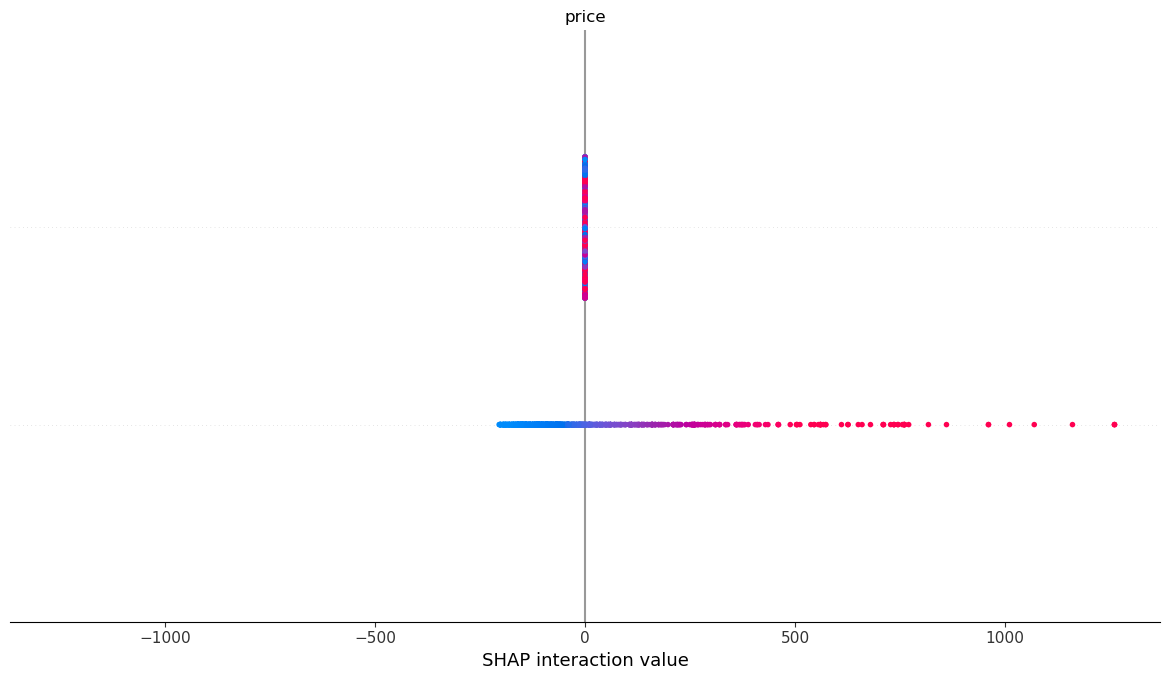

In [20]:
def shap_analysis(df):
    feature_cols = ['price', 'listing_age']
    if not all(col in df.columns for col in feature_cols):
        print("Missing required columns for SHAP analysis.")
        return
    
    X = df[feature_cols]
    explainer = shap.Explainer(lambda x: x, X)  # Dummy model for illustration
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X)

shap_analysis(merged_df)